<center><h1>Visualization Service Development</h1></center>

This is a jupyter notebook for developing visualization services. Create a file like this for each service that is being developed. This is where we will track progress as well as be able to debug code. Please refer to the "Viz DB Service Development Tutorial" notebook for practicing and learning how to interact with data stored in the viz database. To ease the work of development, helper functions have also been created to run SQL code, create maps, and upload shapefiles to an AWS S3 storage bucket. While these function should help in most cases, you can run other python code inside this notebook as well to do more complex operations.

In order to enable a few tools/extensions that we want to use for this notebook please do the following:
<ol>
<li>Run "!pip install nodejs geopandas contextily" on the next cell</li>
<li>Click on the "Commands" tab on the left or press (Ctrl+Shift+C)</li>
<li>Click on "Enable Extension Manager"</li>
<li>Click on "Enable"</li>
<li>Click on the "Extension Manager" tab on the left (looks like a puzzle piece)</li>
<li>Install the "jupyter-widgets/jupyterlab-manager" extension.</li>
<li>You will be prompted to rebuild the notebook. Click on "Rebuild". This may take a bit of time but you will be prompted when it finishes.</li>
</ol> 

In [ ]:
!pip install nodejs geopandas contextily

In [1]:
from helper_functions.shared_functions import *
import pandas as pd

service_name = "srf_max_high_water_arrival_time"
folder = "nwm"
configuration = "short_range"
summary = "Short-Range Maximum High Flow Magnitude Forecast"
description = """
    Depicts expected high flow magnitudes derived from the operational National Water Model (NWM) (v2.1) 
    short-range forecast. Shown are reaches that are expected to have flow at or above bankfull over the next 18 hours. 
    Reaches are colored by the annual exceedance probability of their maximum forecast flow over the next 18 hours. 
    Bankfull flows and annual exceedance probabilities were derived using a 40-year retrospective analysis of the NWM (v2.1). 
    Updated hourly.
"""
tags = "short range forecast, maximum, high flow, magnitude, national water model, nwm"
credits = "National Water Model, NOAA/NWS National Water Center"

load_checklist(service_name)

Checkbox(value=True, description='Update service metadata in first notebook cell', description_tooltip='update…

Checkbox(value=True, description='Have Corey or Tyler add any new dependent datasets to the DB', description_t…

Checkbox(value=True, description='Create SQL for service data', description_tooltip='create_sql')

Checkbox(value=True, description='Check SQL output for accuracy', description_tooltip='check_sql')

Checkbox(value=True, description='Update SQL to save a table in the dev schema', description_tooltip='save_sql…

Checkbox(value=True, description='Create a pro project for the new service', description_tooltip='create_pro_p…

Checkbox(value=False, description='Setup a code review meeting with the team to go over the service', descript…

Checkbox(value=False, description='Complete code review', description_tooltip='finished_code_review')

Checkbox(value=False, description='Implement any service changes from the code review', description_tooltip='i…

Checkbox(value=False, description='Add notebook to repo', description_tooltip='add_notebook_to_repo')

Checkbox(value=False, description='Admin Task - Add SQL to repo (Adding INTO statements)', description_tooltip…

Checkbox(value=False, description='Admin Task - Add pro poject to repo (Updating to use Query Layer)', descrip…

Checkbox(value=False, description='Admin Task - Implement service into the TI environment', description_toolti…

<h2>Create SQL for Service Data</h2>

First we need to create some SQL that will give us the table with the fields that we want. This is similar to the product scripts in the on-prem workflow. If additional datasets are needed, please contact Corey or Tyler about getting those into the DB. 

In [1]:
sql = """
WITH reference_time AS (
     SELECT max(ingest_status.reference_time) AS reference_time
       FROM admin.ingest_status
      WHERE ingest_status.target::text = 'ingest.rnr_max_flows'::text
    )
	
SELECT ingest.rnr_max_flows.feature_id, 
	ingest.rnr_max_flows.feature_id::TEXT AS feature_id_str,
	Name, 
	to_char(REFERENCE_TIME, 'YYYY-MM-DD HH24:MI:SS UTC') AS reference_time,
	STRING_AGG(FORECAST_NWS_LID || ' @ ' || FORECAST_ISSUE_TIME || ' (' || FORECAST_MAX_STATUS || ')', ', ') AS INHERITED_RFC_FORECASTS,
	MAX(forecast_max_value) * 35.31467 AS MAX_FLOW,
	INITCAP(MAX(REPLACE(VIZ_MAX_STATUS, '_', ' '))) AS MAX_STATUS,
	INITCAP(MAX(WATERBODY_STATUS)) AS WATERBODY_STATUS,
	MAX(VIZ_STATUS_LID) AS VIZ_STATUS_LID,
	Strm_Order,
	huc6,
	to_char(now()::timestamp without time zone, 'YYYY-MM-DD HH24:MI:SS UTC') AS update_time,
	geom
FROM INGEST.RNR_MAX_FLOWS
left join derived.channels_conus ON INGEST.RNR_MAX_FLOWS.feature_id = derived.channels_conus.feature_id, reference_time
GROUP BY INGEST.RNR_MAX_FLOWS.FEATURE_ID, feature_id_str, Name, reference_time, Strm_Order, huc6, geom;
"""

run_sql_in_db(sql)

NameError: name 'run_sql_in_db' is not defined

<h2>Check Outputs Through Pandas DataFrame</h2>

When we use the "run_sql_in_db" function, a pandas dataframe is returned. This allows us to inspect the results a little better and dig to make sure the output is what we expect

In [ ]:
sql = """
SELECT 
    maxflows.feature_id,
    maxflows.maxflow_18hour AS max_flow,
    CASE
        WHEN maxflows.maxflow_18hour >= thresholds.rf_50_0_17c THEN '2'::text
        WHEN maxflows.maxflow_18hour >= thresholds.rf_25_0_17c THEN '4'::text
        WHEN maxflows.maxflow_18hour >= thresholds.rf_10_0_17c THEN '10'::text
        WHEN maxflows.maxflow_18hour >= thresholds.rf_5_0_17c THEN '20'::text
        WHEN maxflows.maxflow_18hour >= thresholds.rf_2_0_17c THEN '50'::text
        WHEN maxflows.maxflow_18hour >= thresholds.high_water_threshold THEN '>50'::text
        ELSE NULL::text
    END AS recur_cat,
    thresholds.high_water_threshold AS high_water_threshold,
    thresholds.rf_2_0_17c AS flow_2yr,
    thresholds.rf_5_0_17c AS flow_5yr,
    thresholds.rf_10_0_17c AS flow_10yr,
    thresholds.rf_25_0_17c AS flow_25yr,
    thresholds.rf_50_0_17c AS flow_50yr
FROM cache.max_flows_srf AS maxflows
JOIN derived.recurrence_flows_conus AS thresholds ON maxflows.feature_id = thresholds.feature_id
WHERE thresholds.high_water_threshold > 0 AND maxflows.maxflow_18hour >= thresholds.high_water_threshold
"""

df = run_sql_in_db(sql)

In this example, we can take the dataframe and inspect all the features that have a recurence category of 2%. Interestingly, we will find that many of the features that have a recurrence category of 0, also have recurrence flow values of 0.

In [ ]:
df.loc[df['recur_cat'] == "2"]

Maybe we need to just remove any features that have a 2% flow of 0 or set the recurrence category to "Not Available". We can write some queries in the dataframe to pick out all the features with a 2% flow of 0 to see how extensive this issue is and what the range is for streamflows.

In [ ]:
df.loc[df['flow_50yr'] == 0].sort_values('max_flow')

<h3>Comparing Dataframe to Testing Datasets</h3>

We could also compare the table to a test dataset to ensure that what we are seeing is what we expect. In this case, the outputs are not the same because the same reference times are not being compared

In [ ]:
test_dataset = pd.read_csv("test_datasets/srf_max_high_flow_magnitude_example.csv")

test_dataset.equals(df)

In [ ]:
display(df)
display(test_dataset)

<h2>Check Outputs Through Mapping</h2>

Previously, if we ever wanted to check outputs, we would have to run our python code, create the outputs, and then bring them into Arcgis Pro to verify. With the "run_sql_in_db" function, we can add a keyword argument (return_geodataframe=True) to return a spatially aware dataframe. With this dataframe, we can now plot the outputs directly in the notebook through the plot method. To ease the development, we have created a simple function to map a column (map_column). More complex aps can be created directly through the plot method if desired.

In the first example, we will retrieve the table that is used for srf max high flow magnitude. We can then use the map_column function to create a map with the same categories and symbology to make sure the outputs look how we expect.

In [2]:
sql = """
WITH high_flow_mag AS (
     SELECT 
        maxflows.feature_id,
        maxflows.maxflow_18hour AS max_flow,
            CASE
                WHEN maxflows.maxflow_18hour >= thresholds.rf_50_0_17c THEN '2'::text
                WHEN maxflows.maxflow_18hour >= thresholds.rf_25_0_17c THEN '4'::text
                WHEN maxflows.maxflow_18hour >= thresholds.rf_10_0_17c THEN '10'::text
                WHEN maxflows.maxflow_18hour >= thresholds.rf_5_0_17c THEN '20'::text
                WHEN maxflows.maxflow_18hour >= thresholds.rf_2_0_17c THEN '50'::text
                WHEN maxflows.maxflow_18hour >= thresholds.high_water_threshold THEN '>50'::text
                ELSE NULL::text
            END AS recur_cat,
        thresholds.high_water_threshold AS high_water_threshold,
        thresholds.rf_2_0_17c AS flow_2yr,
        thresholds.rf_5_0_17c AS flow_5yr,
        thresholds.rf_10_0_17c AS flow_10yr,
        thresholds.rf_25_0_17c AS flow_25yr,
        thresholds.rf_50_0_17c AS flow_50yr
    FROM cache.max_flows_srf AS maxflows
    JOIN derived.recurrence_flows_conus AS thresholds ON maxflows.feature_id = thresholds.feature_id
    WHERE thresholds.high_water_threshold > 0::double precision AND maxflows.maxflow_18hour >= thresholds.high_water_threshold
)
SELECT 
    channels.feature_id,
    channels.feature_id::TEXT AS feature_id_str,
    channels.strm_order,
    channels.name,
    channels.huc6,
    channels.nwm_vers,
    high_flow_mag.max_flow,
    high_flow_mag.recur_cat,
    high_flow_mag.high_water_threshold,
    high_flow_mag.flow_2yr,
    high_flow_mag.flow_5yr,
    high_flow_mag.flow_10yr,
    high_flow_mag.flow_25yr,
    high_flow_mag.flow_50yr,
    channels.geom,
    to_char(now()::timestamp without time zone, 'YYYY-MM-DD HH24:MI:SS UTC') AS update_time
FROM derived.channels_conus channels
JOIN high_flow_mag ON channels.feature_id = high_flow_mag.feature_id;
"""

gdf = run_sql_in_db(sql, return_geodataframe=True)

In [ ]:
column = "recur_cat"

map_column(gdf, column)

<AxesSubplot:title={'center':'Short Range Max High Flow Magnitude'}>

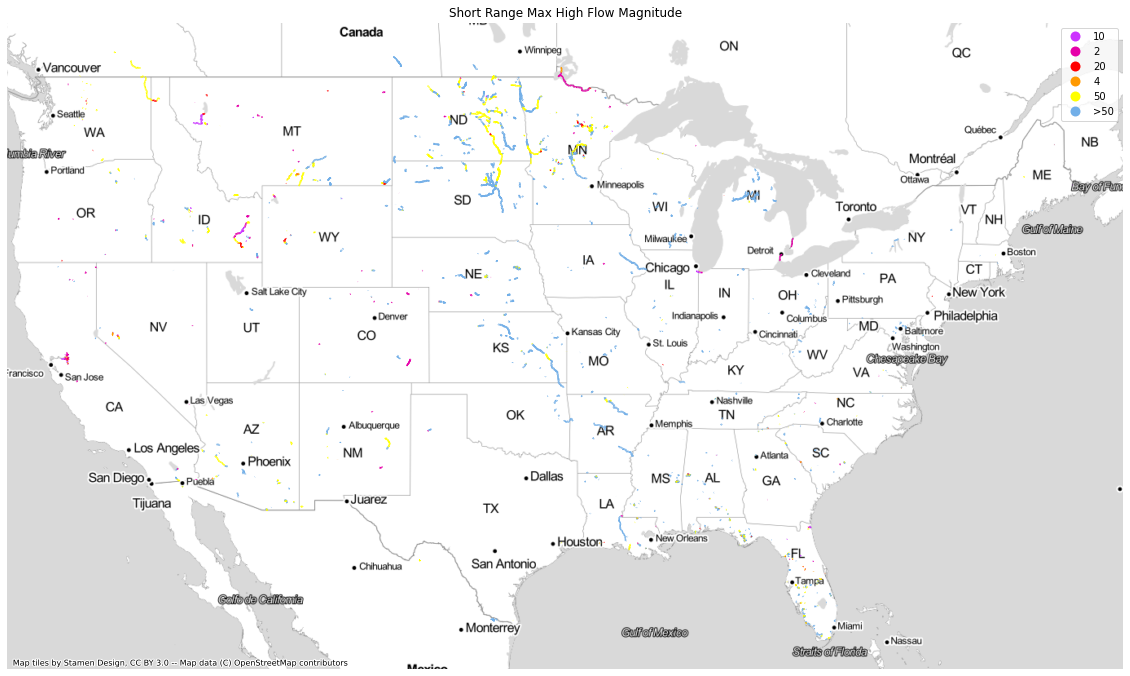

In [3]:
column = "recur_cat"
colormap = {
    '2': '#cc33ff',
    '4': '#e600a9',
    '10': '#ff0000',
    '20': '#ff9900',
    '50': '#ffff00',
    '>50': '#72afe8'
}
title = "Short Range Max High Flow Magnitude"

map_column(gdf, column, colormap, title=title)

<h2>Configuring Pro Project</h2>

When we developed on-prem, we would have to run the python code to create the shapefile or feature class and then setup the pro project accordingly. For hydrovis development, we can follow the same model using the notebook. We have created a helper function called "save_gdf_shapefile_to_s3" to do this. The function will take the geodataframe, save it as a shapefile and then also upload it to S3. You can either download the shapefile from the S3 bucket or from the file explorer within jupyter notebook (under the folder "shapefiles")

In [ ]:
save_gdf_shapefile_to_s3(gdf, "srf_max_high_flow_magnitude")